In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

import matplotlib.pyplot as plt

from torchvision.utils import make_grid

from einops import rearrange
import math

In [2]:
# 1 cross attension
class CrossAttention(nn.Module):
  def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1,):

    # Note: For simplicity reason, we just implemented 1-head attention. 
    # Feel free to implement multi-head attention! with fancy tensor manipulations.
    
    super(CrossAttention, self).__init__()
    self.hidden_dim = hidden_dim
    self.context_dim = context_dim
    self.embed_dim = embed_dim
    self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
    if context_dim is None:
      self.self_attn = True 
      self.key = nn.Linear(hidden_dim, embed_dim, bias=False)     ###########
      self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)  ############
    else:
      self.self_attn = False 
      self.key = nn.Linear(context_dim, embed_dim, bias=False)   #############
      self.value = nn.Linear(context_dim, hidden_dim, bias=False) ############
    
    
  def forward(self, tokens, context=None):
    # tokens: with shape [batch, sequence_len, hidden_dim]
    # context: with shape [batch, contex_seq_len, context_dim]
    if self.self_attn:
        Q = self.query(tokens)
        K = self.key(tokens)  
        V = self.value(tokens) 
    else:
        # implement Q, K, V for the Cross attention 
        Q = self.query(tokens)
        K = self.key(context)
        V = self.value(context)
    #print(Q.shape, K.shape, V.shape)
    ####### YOUR CODE HERE (2 lines)
    scoremats = torch.einsum("bth,bsh->bts", Q, K)         # inner product of Q and K, a tensor 
    attnmats = F.softmax(scoremats/np.sqrt(self.embed_dim), dim=-1)          # softmax of scoremats
    #print(scoremats.shape, attnmats.shape, )
    ctx_vecs = torch.einsum("bts,bsh->bth", attnmats, V)  # weighted average value vectors by attnmats
    return ctx_vecs


class TransformerBlock(nn.Module):
  #The transformer block that combines self-attn, cross-attn and feed forward neural net
  def __init__(self, hidden_dim, context_dim):
    super(TransformerBlock, self).__init__()
    self.attn_self = CrossAttention(hidden_dim, hidden_dim, )
    self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

    self.norm1 = nn.LayerNorm(hidden_dim)
    self.norm2 = nn.LayerNorm(hidden_dim)
    self.norm3 = nn.LayerNorm(hidden_dim)
    # implement a 2 layer MLP with K*hidden_dim hidden units, and nn.GeLU nonlinearity #######
    self.ffn  = nn.Sequential(nn.Linear(hidden_dim, 3*hidden_dim),
                nn.GELU(), nn.Linear(3*hidden_dim, hidden_dim) )
    
    
  def forward(self, x, context=None):
    # Notice the + x as residue connections
    x = self.attn_self(self.norm1(x)) + x
    # Notice the + x as residue connections
    x = self.attn_cross(self.norm2(x), context=context) + x
    # Notice the + x as residue connections
    x = self.ffn(self.norm3(x)) + x
    return x 

class SpatialTransformer(nn.Module):
  def __init__(self, hidden_dim, context_dim):
    super(SpatialTransformer, self).__init__()
    self.transformer = TransformerBlock(hidden_dim, context_dim)

  def forward(self, x, context=None):
    b, c, h, w = x.shape
    x_in = x
    # Combine the spatial dimensions and move the channel dimen to the end
    x = rearrange(x, "b c h w->b (h w) c")
    # Apply the sequence transformer
    x = self.transformer(x, context)
    # Reverse the process
    x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
    # Residue 
    return x + x_in

In [26]:
# 2 U net

class UNet_Tranformer(nn.Module):
  # A time-dependent score-based model built upon U-Net architecture.

  #channels=[32, 64, 128, 256]
  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256, 
               text_dim=256, nClass=10):
    #Initialize a time-dependent score-based network.

    #Args:
    #  marginal_prob_std: A function that takes time t and gives the standard
    #    deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
    #  channels: The number of channels for feature maps of each resolution.
    #  embed_dim: The dimensionality of Gaussian random feature embeddings of time.
    #  text_dim:  the embedding dimension of text / digits. 
    #  nClass:    number of classes you want to model.
    
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
        GaussianFourierProjection(embed_dim=embed_dim),
        nn.Linear(embed_dim, embed_dim)
        )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.attn1 = SpatialTransformer(channels[0], text_dim) 
    
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.attn2 = SpatialTransformer(channels[1], text_dim) 
    
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.attn3 = SpatialTransformer(channels[2], text_dim) 
    
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    
    # YOUR CODE: interleave some attention layers with conv layers
    self.attn4 = SpatialTransformer(channels[3], text_dim)                        ######################################

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])   

    self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)     #  + channels[2]
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    
    self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)     #  + channels[1]
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1) #  + channels[0]
    
    # The swish activation function
    self.act = nn.SiLU() # lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
    self.cond_embed = nn.Embedding(nClass, text_dim)
  
  def forward(self, x, t, y=None): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.time_embed(t))    
    y_embed = self.cond_embed(y).unsqueeze(1)
    
    #print("==================debug====================")
    #print(x.shape)        #torch.Size([1024, 1, 28, 28])
    #print(embed.shape)    #torch.Size([1024, 256])
    #print(y_embed.shape)  #torch.Size([1024, 1, 256])
    # Encoding path
    h1 = self.conv1(x) + self.dense1(embed) 
    #print(h1.shape)       #torch.Size([1024, 32, 26, 26])
    # output size = ( input size - kernel size + 2 * padding ) / stride + 1
    # output size = ( 28         - 3           + 2 * 0       ) / 1 + 1 = 26
    ## Incorporate information from t
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    #h1 = self.attn1(h1, y_embed) # Use your attention layers
    
    h2 = self.conv2(h1) + self.dense2(embed)
    h2 = self.act(self.gnorm2(h2))
    h2 = self.attn2(h2, y_embed) # Use your attention layers
    #print(h2.shape)       #torch.Size([1024, 64, 12, 12])
    # output size = ( input size - kernel size + 2 * padding ) / stride + 1
    # output size = ( 26         - 3           + 2 * 0       ) / 2 + 1 = 12
    
    
    h3 = self.conv3(h2) + self.dense3(embed)
    h3 = self.act(self.gnorm3(h3))
    h3 = self.attn3(h3, y_embed) # Use your attention layers
    #print(h3.shape)       #torch.Size([1024, 128, 5, 5])
    # output size = ( input size - kernel size + 2 * padding ) / stride + 1
    # output size = ( 12         - 3           + 2 * 0       ) / 2 + 1 = 5
    
    
    h4 = self.conv4(h3) + self.dense4(embed)
    h4 = self.act(self.gnorm4(h4))
    # Your code: Use your additional attention layers! 
    h4 = self.attn4(h4, y_embed)       ##################### ATTENTION LAYER COULD GO HERE IF ATTN4 IS DEFINED
    #print(h4.shape)       #torch.Size([1024, 256, 2, 2])
    # output size = ( input size - kernel size + 2 * padding ) / stride + 1
    # output size = ( 5         - 3           + 2 * 0       ) / 2 + 1 = 2
    
    
    
    # Decoding path
    h = self.tconv4(h4) + self.dense5(embed)
    #print(h.shape)        #torch.Size([1024, 128, 5, 5])
    # output size = ( input size - 1 ) * stride - 2 * padding + kernel size + output_padding
    # output size = ( 2          - 1 ) * 2      - 2 * 0       + 3              = 5
    ## Skip connection from the encoding path
    h = self.act(self.tgnorm4(h))
    
    
    h = self.tconv3(h + h3) + self.dense6(embed)
    #print(h.shape)        #torch.Size([1024, 64, 12, 12])
    # output size = ( input size - 1 ) * stride - 2 * padding + kernel size + output_padding
    # output size = ( 5          - 1 ) * 2      - 2 * 0       + 3           + 1             = 12    
    
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(h + h2) + self.dense7(embed)
    #print(h.shape)        #torch.Size([1024, 32, 26, 26])
    # output size = ( input size - 1 ) * stride - 2 * padding + kernel size + output_padding
    # output size = ( 12          - 1 ) * 2      - 2 * 0       + 3           + 1             = 26 
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(h + h1)
    #print(h.shape)        #torch.Size([1024, 1, 28, 28])
    # output size = ( input size - 1 ) * stride - 2 * padding + kernel size + output_padding
    # output size = ( 26          - 1 ) * 1      - 2 * 0       + 3           + 0             = 28 
    
    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    
    # the h is the noise image
    return h


In [27]:
# 3 show the image result
def show_images(images, title=""):
    # Shows the provided images as sub-pictures in a square

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [28]:
# 4 other nn, position encoding

#@title Get some modules to let time interact

class GaussianFourierProjection(nn.Module):
  # Gaussian random features for encoding time steps.  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights (frequencies) during initialization. 
    # These weights (frequencies) are fixed during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    # Cosine(2 pi freq x), Sine(2 pi freq x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  # A fully connected layer that reshapes outputs to feature maps.
  # Allow time repr to input additively from the side of a convolution layer.
  
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None] 
    # this broadcast the 2d tensor to 4d, add the same value across space. 



#@title Diffusion constant and noise strength
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  # Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  # Args:    
  #  t: A vector of time steps.
  #  sigma: The $\sigma$ in our SDE.  
  
  # Returns:
  #  The standard deviation.
      
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  # Compute the diffusion coefficient of our SDE.

  # Args:
  #  t: A vector of time steps.
  #  sigma: The $\sigma$ in our SDE.
  
  # Returns:
  #  The vector of diffusion coefficients.
  
  return torch.tensor(sigma**t, device=device)
  
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [29]:
# 5 model information and action

# Create an instance of YourModelClass
score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# Function to calculate the size of the model
def model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params / 1e6  # Return the size in million parameters

# Get the size of the model
size_in_mb = model_size(score_model)
print(f"Model size: {size_in_mb:.2f} MB")

# Load the saved state dictionary
state_dict = torch.load('ckpt_transformer.pth')

# Load the state dictionary into the model
score_model.load_state_dict(state_dict)


Model size: 2.15 MB


<All keys matched successfully>

In [30]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
  # The loss function for training score-based generative models.

  # Args:
  #  model: A PyTorch model instance that represents a 
  #    time-dependent score-based model.
  #  x: A mini-batch of training data.    
  #  marginal_prob_std: A function that gives the standard deviation of 
  #    the perturbation kernel.
  #  eps: A tolerance value for numerical stability.
  
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t, y=y)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [31]:
#@title Training model

continue_training = True #@param {type:"boolean"}
if not continue_training:
  print("initilize new score model...")
  score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
  score_model = score_model.to(device)


n_epochs =   100#@param {'type':'integer'}
## size of a mini-batch
batch_size =  1024 #@param {'type':'integer'}
## learning rate
lr=10e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in tqdm(data_loader):
    x = x.to(device)    
    loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  scheduler.step()
  lr_current = scheduler.get_last_lr()[0]
  print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt_transformer.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

/tmp/ipykernel_490364/1799332901.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 59.462793 lr 9.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

1 Average Loss: 22.596328 lr 9.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

2 Average Loss: 19.943652 lr 9.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

3 Average Loss: 18.874810 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

4 Average Loss: 18.461450 lr 9.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

5 Average Loss: 18.522418 lr 8.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

6 Average Loss: 18.218516 lr 8.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

7 Average Loss: 18.050880 lr 8.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

8 Average Loss: 19.023326 lr 8.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

9 Average Loss: 18.076752 lr 8.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

10 Average Loss: 17.971799 lr 8.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

11 Average Loss: 17.841673 lr 7.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

12 Average Loss: 17.351518 lr 7.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

13 Average Loss: 17.959933 lr 7.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

14 Average Loss: 17.679222 lr 7.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

15 Average Loss: 17.257268 lr 7.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

16 Average Loss: 17.054860 lr 7.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

17 Average Loss: 17.475249 lr 7.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

18 Average Loss: 17.195926 lr 6.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

19 Average Loss: 17.293317 lr 6.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

20 Average Loss: 17.161443 lr 6.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

21 Average Loss: 17.014819 lr 6.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

22 Average Loss: 17.172263 lr 6.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

23 Average Loss: 17.110042 lr 6.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

24 Average Loss: 17.156526 lr 6.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

25 Average Loss: 16.998090 lr 5.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

26 Average Loss: 16.976849 lr 5.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

27 Average Loss: 16.661058 lr 5.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

28 Average Loss: 16.891891 lr 5.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

29 Average Loss: 16.511144 lr 5.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

30 Average Loss: 16.976787 lr 5.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

31 Average Loss: 16.681080 lr 5.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

32 Average Loss: 16.612700 lr 5.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

33 Average Loss: 16.682454 lr 5.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

34 Average Loss: 16.565501 lr 4.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

35 Average Loss: 16.835328 lr 4.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

36 Average Loss: 16.683491 lr 4.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

37 Average Loss: 16.342753 lr 4.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

38 Average Loss: 16.797886 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

39 Average Loss: 16.399765 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

40 Average Loss: 16.431224 lr 4.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

41 Average Loss: 16.474976 lr 4.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

42 Average Loss: 16.490587 lr 4.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

43 Average Loss: 16.399503 lr 4.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

44 Average Loss: 16.094243 lr 4.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

45 Average Loss: 16.327355 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

46 Average Loss: 16.355874 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

47 Average Loss: 16.041542 lr 3.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

48 Average Loss: 16.291093 lr 3.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

49 Average Loss: 16.062191 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

50 Average Loss: 16.035115 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

51 Average Loss: 16.153144 lr 3.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

52 Average Loss: 16.045512 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

53 Average Loss: 16.214030 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

54 Average Loss: 16.079396 lr 3.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

55 Average Loss: 16.074616 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

56 Average Loss: 16.147399 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

57 Average Loss: 15.972788 lr 3.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

58 Average Loss: 16.037046 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

59 Average Loss: 16.095634 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

60 Average Loss: 15.802841 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

61 Average Loss: 15.924102 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

62 Average Loss: 15.938078 lr 2.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

63 Average Loss: 15.854820 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

64 Average Loss: 15.890369 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

65 Average Loss: 15.641385 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

66 Average Loss: 15.726068 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

67 Average Loss: 15.967881 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

68 Average Loss: 15.801222 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

69 Average Loss: 15.851748 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

70 Average Loss: 15.828958 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

71 Average Loss: 15.825669 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

72 Average Loss: 15.760899 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

73 Average Loss: 15.623521 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

74 Average Loss: 15.782175 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

75 Average Loss: 16.058268 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

76 Average Loss: 15.785809 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

77 Average Loss: 15.701423 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

78 Average Loss: 15.607373 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

79 Average Loss: 15.640840 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

80 Average Loss: 15.667152 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

81 Average Loss: 15.642673 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

82 Average Loss: 15.804816 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

83 Average Loss: 15.685561 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

84 Average Loss: 15.583893 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

85 Average Loss: 15.601674 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

86 Average Loss: 15.581751 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

87 Average Loss: 15.628468 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

88 Average Loss: 15.544418 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

89 Average Loss: 15.626860 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

90 Average Loss: 15.343292 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

91 Average Loss: 15.482217 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

92 Average Loss: 15.472912 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

93 Average Loss: 15.562013 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

94 Average Loss: 15.602134 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

95 Average Loss: 15.661301 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

96 Average Loss: 15.638861 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

97 Average Loss: 15.688277 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

98 Average Loss: 15.567179 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

99 Average Loss: 15.513846 lr 2.0e-04


In [39]:
#@title Sampler code
num_steps = 500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
              marginal_prob_std,
              diffusion_coeff, 
              batch_size=64, 
              x_shape=(1, 28, 28),
              num_steps=num_steps, 
              device='cuda', 
              eps=1e-3, y=None):
  # Generate samples from score-based models with the Euler-Maruyama solver.

  # Args:
  # score_model: A PyTorch model that represents the time-dependent score-based model.
  #  marginal_prob_std: A function that gives the standard deviation of
  #    the perturbation kernel.
  #  diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
  #  batch_size: The number of samplers to generate by calling this function once.
  #  num_steps: The number of sampling steps. 
  #    Equivalent to the number of discretized time steps.
  #  device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
  #  eps: The smallest time step for numerical stability.
  
  # Returns:
  #  Samples.    
  
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, *x_shape, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

/tmp/ipykernel_490364/1799332901.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_490364/1799332901.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


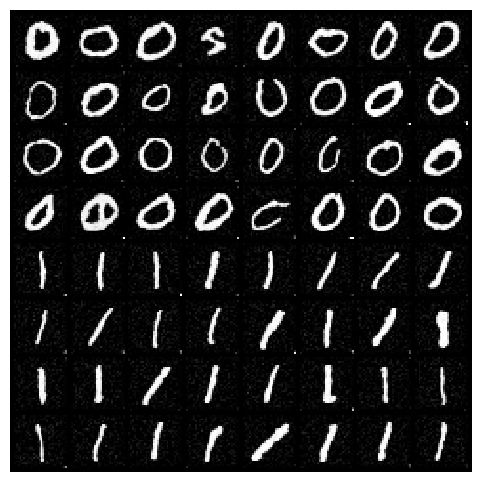

In [48]:
## Load the pre-trained checkpoint from disk.
# device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
# ckpt = torch.load('ckpt.pth', map_location=device)
# score_model.load_state_dict(ckpt)
digit = 3 #@param {'type':'integer'}
sample_batch_size = 64 #@param {'type':'integer'}
num_steps = 500 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
# score_model.eval()
## Generate samples using the specified sampler.

y_input = digit*torch.ones(sample_batch_size, dtype=torch.long)

half_size = sample_batch_size // 2
y_input = torch.cat([0 * torch.ones(half_size, dtype=torch.long), 1 * torch.ones(half_size, dtype=torch.long)], dim=0)


samples = sampler(score_model, 
        marginal_prob_std_fn,
        diffusion_coeff_fn, 
        sample_batch_size, 
        num_steps=num_steps,
        device=device,
        y=y_input)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()